In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from performance_measures import c_index, brier_score, weighted_c_index, weighted_brier_score,log_partial_lik
from neural_models import negLogLikelihood, linearCoxPH_Regression, MLP, negLogLikelihood_per_sample
from fairness_measures import individual_fairness, group_fairness, intersect_fairness, individual_fairness_scale, CI, C_index_difference

from sksurv.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import brier_score_loss
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.metrics import concordance_index_ipcw,cumulative_dynamic_auc
from sklearn.linear_model import QuantileRegressor
from sksurv.util import Surv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import argparse
from scipy import optimize
import datetime

In [2]:
args = {'dataset': 'FLC', 
        'model': 'Linear',
        'gpuid': '0',
        'epochs': 500,
        'lr': 0.01,
        'with_scale': True,
        'eps': 0.1,
        'seed': 7,
        'protect_index': 0,
        'train_or_evaluation': 1}

In [3]:
from compute_survival_function import predict_survival_function  

#The function below ensures that we seed all random generators with the same value to get reproducible results
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

def threshplus(x):
    y = x.copy()
    y[y<0]=0
    return y

def threshplus_tensor(x):
    y = x.clone()
    y[y<0]=0
    return y

def loss_map_chi_factory(loss_values, eps):
    # return lambda x: np.sqrt(2)*(1.0/eps-1.0)*np.sqrt(np.mean(threshplus(loss_values-x)**2.0)) + x
    return lambda x: np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(loss_values - x) ** 2.0)) + x

def loss_map_chi_factory_tensor(loss_values, eps, opt_eta):
    # return np.sqrt(2)*(1.0/eps-1.0)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta
    return np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta

In [4]:
# FLC data:
from utilities import prepare_data
from utilities import check_arrays_survival
from flc_data_preprocess import flc_preprocess
from support_data_preprocess import support_preprocess
from compas_data_preprocess import compas_preprocess
from seer_data_preprocess import seer_preprocess

#Survival Data
if args['dataset'] == 'FLC':
    data_x, data_y, protect_attr = flc_preprocess()
elif args['dataset'] == 'SUPPORT':
    data_x, data_y, protect_attr = support_preprocess()
elif args['dataset'] == 'COMPAS':
    data_x, data_y, protect_attr = compas_preprocess()
elif args['dataset'] == 'SEER':
    data_x, data_y, protect_attr = seer_preprocess()
else:
    print('unknown')

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"], random_state=args['seed'])
data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"], random_state=args['seed'])
#
data_X_train, data_event_train, data_time_train = check_arrays_survival(data_X_train, data_y_train)
data_X_train, data_event_train, data_time_train, S_train = prepare_data(data_X_train, data_event_train, data_time_train, S_train)

if args['train_or_evaluation']==0:
    data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_dev, data_y_dev)
    data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_dev)
    data_y_test = data_y_dev
else:
    data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
    data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)
#
intersectionalGroups = np.unique(S_train,axis=0) # all intersecting groups, i.e. black-women, white-man etc 
# data normalization: mean subtraction method to compute euclidean distance
scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)

# Simulation

In [ ]:
from numpy.random import normal, uniform
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_distances
set_random_seed()
def simulate_dgp_1(sim_n=200, sim_tau=0.5, M = 14.0):
    sim_X = uniform(low=0.0, high=1.0, size=(sim_n, 1))
    sim_beta = np.array([3, 5])
    sim_eps = normal(loc=0.0, scale=1.0, size=sim_n) - norm.ppf(sim_tau) # error term with tau-th quantile = 0
    sim_failure_time = sim_beta[0] + sim_X @ sim_beta.reshape(-1,1)[1:, 0] + sim_eps
    sim_censor_time = uniform(low=0.0, high=M, size=sim_n) # uniform censoring
    sim_event = (sim_failure_time <= sim_censor_time) # event indicator
    sim_time = sim_failure_time*sim_event + sim_censor_time*(~sim_event) # observed time
    return sim_X, sim_failure_time, sim_censor_time, sim_event, sim_time

class Local_KM:
    def __init__(self, X, event, time, kernel, bw, is_minmax_normalize = True):
        if is_minmax_normalize:
            self.scaler = MinMaxScaler()
            self.X = self.scaler.fit_transform(X)
        else:
            self.X = X
        self.event = event
        self.time = time
        self.kernel = kernel # only support squared euclidean distance
        self.bw = bw

    def predict(self, time_test, X_test):
        dist_mat_test_to_train = pairwise_distances(self.scaler.transform(X_test), self.X, metric='sqeuclidean')
        B_mat = self.kernel(dist_mat_test_to_train/self.bw)
        B_mat += 10e-10
        indicator_mat = self.time.reshape(-1, 1) >= self.time.reshape(1, -1)
        # eta = (self.time.reshape(-1, 1) <= t.reshape(1, -1))*self.event.reshape(-1, 1)
        eta = (self.time.reshape(1, -1) <= time_test.reshape(-1, 1))*self.event.reshape(1, -1)
        product_term_mat = (1 - B_mat/np.matmul(B_mat, indicator_mat))**eta
        F_hat = 1 - np.product(product_term_mat, axis=1)
        return F_hat
    
def augment_data(X, time, event, tau, F_hat):
    """ Augment the data for Redistribution of Mass (RM) method of CQR"""
    augment_index = np.where(((1 - event)*(F_hat < tau)))[0]
    weight_train = np.ones(len(event))
    weight_train[augment_index] = ((tau - F_hat)/(1 - F_hat + 10e-10))[augment_index]
    weight_train = np.concatenate([weight_train, 1 - weight_train[augment_index]])

    n_augment = len(augment_index)
    augment_index = np.concatenate([np.arange(len(event)), augment_index])
    X_augmented = X[augment_index]
    event_augmented = event[augment_index]
    time_augmented = np.concatenate([time, np.repeat(time.max()*100, n_augment)])
    return X_augmented, time_augmented, event_augmented, weight_train

class LocallyReweightedCQR:
    def __init__(self):
        self.X_train = None
        self.event_train = None
        self.time_train = None
        self.beta = None
        
    def compute_weight(self, X_train, event_train, time_train, tau, kernel=lambda x: np.exp(-x), bw=0.01, is_minmax_normalize=True):
        self.local_km_model = Local_KM(X_train, event_train, time_train, kernel, bw, is_minmax_normalize)
        F_hat = self.local_km_model.predict(time_train, X_train)
        self.weight_train = np.ones(len(event_train))
        augment_index = np.where(((1 - event_train)*(F_hat < tau)))[0]
        self.weight_train[augment_index] = ((tau - F_hat)/(1 - F_hat + 10e-10))[augment_index]
        self.weight_train = self.weight_train.reshape((-1,1))
        self.weight_train = np.concatenate([self.weight_train, 1 - self.weight_train], axis = 1)
        # sim_X_augmented, sim_time_augmented, sim_event_augmented, weight_train = augment_data(X_train, time_train, event_train, tau, F_hat)

    def quantile_loss(self, y_true, y_pred, tau):
        """ Quantile loss function"""
        return np.maximum(tau * (y_true - y_pred), (tau - 1) * (y_true - y_pred))
        
    def censored_quantile_loss(self, beta, X_train, time_train, tau, weight_train):
        quantile_pred = np.dot(X_train, beta)
        return np.dot(self.quantile_loss(time_train, quantile_pred, tau), weight_train[:,0]) + np.dot(self.quantile_loss(100*np.max(time_train), quantile_pred, tau), weight_train[:,1])
    
    def fit():

In [6]:
def quantile_loss(y_true, y_pred, tau):
    """ Quantile loss function for CQR """
    return np.mean(np.maximum(tau * (y_true - y_pred), (tau - 1) * (y_true - y_pred)))

## CQR

In [7]:
sim_n = 200
sim_tau = 0.5
sim_B = 100  # Number of bootstrap samples
sim_cqr_beta = np.zeros((sim_B, 2))  # Placeholder for CQR beta coefficients
censor_rate = 0
set_random_seed()
for i in range(sim_B):
    sim_X, sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_dgp_1(sim_n=sim_n, sim_tau=sim_tau, M = 14)
    censor_rate += sim_event.mean()
    local_km_model = Local_KM(sim_X, sim_event, sim_time, lambda x: np.exp(-x), 0.01)
    F_hat = local_km_model.predict(sim_time, sim_X)
    sim_X_augmented, sim_time_augmented, sim_event_augmented, weight_train = augment_data(sim_X, sim_time, sim_event, sim_tau, F_hat)
    cqr_model = QuantileRegressor(quantile=sim_tau, alpha=0.0, fit_intercept=True, solver='highs')
    cqr_model.fit(sim_X_augmented, sim_time_augmented, sample_weight=weight_train)
    sim_cqr_beta[i, 0] = cqr_model.intercept_
    sim_cqr_beta[i, 1] = cqr_model.coef_

censor_rate /= sim_B
censor_rate = 1 - censor_rate
cqr_beta = np.array([3, 5])
diff = sim_cqr_beta - cqr_beta
bias = diff.mean(axis=0)
rmse = diff.std(axis=0)
print(f"Bias: {bias}, RMSE: {rmse}, Censor Rate: {censor_rate}")

Bias: [-0.00239328  0.05372781], RMSE: [0.22098931 0.37796986], Censor Rate: 0.39849999999999997


In [23]:
model = LocallyReweightedCQR()
model.compute_weight(sim_X, sim_event, sim_time, 0.5)

In [24]:
model.weight_train

array([[1.        , 0.        ],
       [0.4583798 , 0.5416202 ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.47364431, 0.52635569],
       [0.3955899 , 0.6044101 ],
       [1.        , 0.        ],
       [0.49998747, 0.50001253],
       [0.49999999, 0.50000001],
       [1.        , 0.        ],
       [0.49961227, 0.50038773],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.4596086 , 0.5403914 ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.0446052 , 0.9553948 ],
       [1.        , 0.        ],
       [1.

## DRO simulations

In [63]:
def simulate_cqr_dgp(sim_beta, sim_n=200, sim_tau=0.5, n_cov=1, cov_dist=["uniform", 0.0, 1.0], censor_dist=["uniform", 0.0, 14.0]):
    def simulate_dist(dist_params, size):
        if dist_params[0] == "uniform":
            return uniform(low=dist_params[1], high=dist_params[2], size=size)
        elif dist_params[0] == "normal":
            return normal(loc=dist_params[1], scale=dist_params[2], size=size)
        else:
            raise ValueError("Unsupported distribution type")
    sim_X = simulate_dist(cov_dist, (sim_n, n_cov))
    sim_eps = normal(loc=0.0, scale=1.0, size=sim_n) - norm.ppf(sim_tau) # error term with tau-th quantile = 0
    sim_failure_time = sim_beta[0] + np.dot(sim_X, sim_beta[1:]) + sim_eps
    sim_censor_time = simulate_dist(censor_dist, sim_n)
    sim_event = (sim_failure_time <= sim_censor_time) # event indicator
    sim_time = sim_failure_time*sim_event + sim_censor_time*(~sim_event) # observed time
    return sim_X, sim_failure_time, sim_censor_time, sim_event, sim_time

In [69]:
sim_X, sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_cqr_dgp(sim_beta=cqr_beta, sim_n=200, sim_tau=0.5, n_cov=1, cov_dist=["normal", 0.0, 1.0], censor_dist=["uniform", 0.0, 14.0])

In [162]:
set_random_seed()
# Training set parameters
sim_n_train = 500 # Number of training samples in one batch
sim_tau = 0.95 # Quantile to estimate
sim_B = 500  # Number of bootstrap samples
n_cov = 5 # Number of covariates

# Testing set parameters (distributional shift)
sim_n_test = 10000 # Number of testing samples in one batch
shift_loc = 0.5 # Location for beta coefficients shift
shift_scale = 0.1 # Shift scale for beta coefficients

# Simulation
sim_beta = normal(loc=0.0, scale=1.0, size=n_cov + 1)  # Simulated beta coefficients
sim_beta_shifted = sim_beta + normal(loc=shift_loc, scale=shift_scale, size=n_cov + 1)  # Shifted beta coefficients
sim_cqr_beta = np.zeros((sim_B, n_cov + 1))  # Placeholder for CQR beta coefficients
sim_loss_test = np.zeros(sim_B)  # Placeholder for test loss
# censor_rate = 0
censor_mean = sim_beta[0] - norm.ppf(sim_tau) - norm.ppf(0.4)*np.sqrt(np.dot(sim_beta[1:], sim_beta[1:]) + 2)
for i in range(sim_B):
    # Training set generation
    sim_X, sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_cqr_dgp(sim_beta=sim_beta, 
                                                                                     sim_n=sim_n_train, sim_tau=sim_tau, n_cov=n_cov, 
                                                                                     cov_dist=["normal", 0.0, 1.0], 
                                                                                     censor_dist=["normal", censor_mean, 1.0])
    # censor_rate += sim_event.mean()
    local_km_model = Local_KM(sim_X, sim_event, sim_time, lambda x: np.exp(-x), 0.01)
    F_hat = local_km_model.predict(sim_time, sim_X)
    sim_X_augmented, sim_time_augmented, sim_event_augmented, weight_train = augment_data(sim_X, sim_time, sim_event, sim_tau, F_hat)
    cqr_model = QuantileRegressor(quantile=sim_tau, alpha=0.0, fit_intercept=True, solver='highs')
    cqr_model.fit(sim_X_augmented, sim_time_augmented, sample_weight=weight_train)
    sim_cqr_beta[i, 0] = cqr_model.intercept_
    sim_cqr_beta[i, 1:] = cqr_model.coef_

    # Testing set generation
    sim_X_test, sim_failure_time_test, sim_censor_time_test, sim_event_test, sim_time_test = simulate_cqr_dgp(sim_beta=sim_beta_shifted, 
                                                                                                                sim_n=sim_n_test, sim_tau=sim_tau, n_cov=n_cov, 
                                                                                                                cov_dist=["normal", 0.0, 1.0], 
                                                                                                                censor_dist=["normal", censor_mean, 1.0])
    
    quantile_pred = cqr_model.predict(sim_X_test)
    # sim_loss_test[i] = quantile_loss(sim_time_test, quantile_pred, sim_tau)
    sim_loss_test[i] = np.mean((sim_beta_shifted[0] + np.dot(sim_X_test, sim_beta_shifted[1:]) - quantile_pred)**2)  # Using mean absolute error as a loss function

In [163]:
diff = sim_cqr_beta - sim_beta
bias = diff.mean(axis=0)
rmse = diff.std(axis=0)
print(f"Bias: {bias}, RMSE: {rmse}\nCensor Rate: {1 - sim_event.mean()}")

Bias: [-0.35340284  0.05708369  0.05491011  0.09537443 -0.0829458   0.21946099], RMSE: [0.14691833 0.11614278 0.11968004 0.12798962 0.11967814 0.1639043 ]
Censor Rate: 0.388


In [157]:
sim_beta

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ])

In [165]:
sim_loss_test.mean()**0.5

1.4859305283679392

(array([ 1.,  1.,  4.,  7., 22., 50., 48., 36., 22.,  9.]),
 array([-17.98743186, -14.7308317 , -11.47423154,  -8.21763138,
         -4.96103123,  -1.70443107,   1.55216909,   4.80876925,
          8.06536941,  11.32196956,  14.57856972]),
 <BarContainer object of 10 artists>)

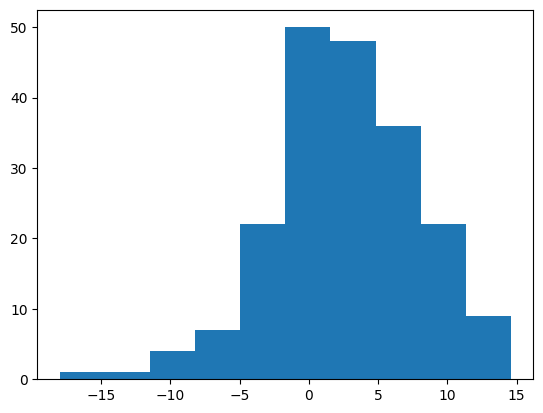

In [72]:
from matplotlib import pyplot as plt
plt.hist(sim_failure_time)

In [ ]:
np.dot(sim_X, cqr_beta[1])

array([[0.10039333],
       [0.97275282],
       [0.0095748 ],
       [0.45543118],
       [0.81085683],
       [0.78001388],
       [0.06413688],
       [0.87471135],
       [0.85630963],
       [0.53135207],
       [0.37807862],
       [0.49465001],
       [0.86172838],
       [0.88137806],
       [0.97683484],
       [0.69498226],
       [0.66053796],
       [0.22890842],
       [0.147044  ],
       [0.77961088],
       [0.90389541],
       [0.3883962 ],
       [0.16548612],
       [0.43338058],
       [0.49883089],
       [0.99964079],
       [0.26723552],
       [0.04488118],
       [0.22978819],
       [0.26740881],
       [0.41229027],
       [0.71089572],
       [0.94368305],
       [0.34399921],
       [0.75735672],
       [0.08213307],
       [0.74110338],
       [0.9398945 ],
       [0.59422156],
       [0.1852225 ],
       [0.59632923],
       [0.8395928 ],
       [0.7299749 ],
       [0.50267069],
       [0.98888542],
       [0.34969887],
       [0.85104896],
       [0.706